In [47]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics

import numpy as np
import shutil
from random import shuffle
import os
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import random
from keras.preprocessing.image import ImageDataGenerator
import math
import time
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

#### MOUNT GOOGLE DRIVE TO THE PROJECT DIRECTORY


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Extract the training and testing datasets


In [3]:
!cp  'drive/My Drive/datasets/MODEL2/model2.tar.gz' 'model2.tar.gz'
!tar -xvf  'model2.tar.gz' 

Streaming output truncated to the last 5000 lines.
MODEL2/train/LEVEL2/-8.369964757035406_-8.36772344522112_41.31671209990977_41.31851292819325.jpg
MODEL2/train/LEVEL2/-8.369964757035406_-8.36772344522112_41.57422480300543_41.57602555040913.jpg
MODEL2/train/LEVEL2/-8.372206068849692_-8.369964757035406_38.778785923010545_38.78058754241857.jpg
MODEL2/train/LEVEL2/-8.372206068849692_-8.369964757035406_41.262686988566706_41.26448783380688.jpg
MODEL2/train/LEVEL2/-8.374447380663979_-8.372206068849692_37.351729117904185_37.35353117586789.jpg
MODEL2/train/LEVEL2/-8.374447380663979_-8.372206068849692_37.83826475424321_37.84006666329584.jpg
MODEL2/train/LEVEL2/-8.374447380663979_-8.372206068849692_39.920900570266376_39.92270183516657.jpg
MODEL2/train/LEVEL2/-8.374447380663979_-8.372206068849692_40.21810168077047_40.219902852984816.jpg
MODEL2/train/LEVEL2/-8.374447380663979_-8.372206068849692_40.565717494755226_40.56751855835829.jpg
MODEL2/train/LEVEL2/-8.374447380663979_-8.372206068849692_41.23

#### GET THE LIST OF FILES IN THE TESTING DATASET

In [14]:
def get_test_dataset(PATH,categories):
    
    test  = dict()
    validate = dict()
    
    for i in categories:        
        test[i]  = os.listdir(f'{PATH}/{i}/')

    for i in test:
        print(f"test {i}: {len(test[i])}")
        
    return test

#### SHOW SAMPLE IMAGES FOR EACH OF THE CATEGORIES



In [15]:
def show_sample_images(test,categories):
    for categorie in categories:
        sample_normal = random.sample(test[categorie],6)
        print(sample_normal)
        f,ax = plt.subplots(2,3,figsize=(15,9))

        for i in range(0,6):
            im = cv2.imread(f'{PATH}/{categorie}/{sample_normal[i]}')
            ax[i//3,i%3].imshow(im)
            ax[i//3,i%3].axis('off')
        f.suptitle(f'{categorie.upper()}')
        plt.show()

In [16]:
PATH = "MODEL2/test"
image_width = 128
image_height = 128
categories =  ['LEVEL1','LEVEL2','LEVEL3']
test = get_test_dataset(PATH,categories)

test LEVEL1: 748
test LEVEL2: 748
test LEVEL3: 748


['-7.500335773092398_-7.498094461278111_40.13704834932267_40.13884954683085.jpg', '-8.464099853235423_-8.461858541421138_40.356790295812324_40.35859142471936.jpg', '-7.6146426756209875_-7.612401363806702_39.00398403039755_39.005785580131175.jpg', '-8.486512971378284_-8.484271659563996_39.605670575208734_39.60747193823071.jpg', '-9.25976554730699_-9.257524235492703_38.74455504845052_38.74635667843889.jpg', '-8.302725402606823_-8.300484090792537_41.1564361192244_41.15823699780108.jpg']


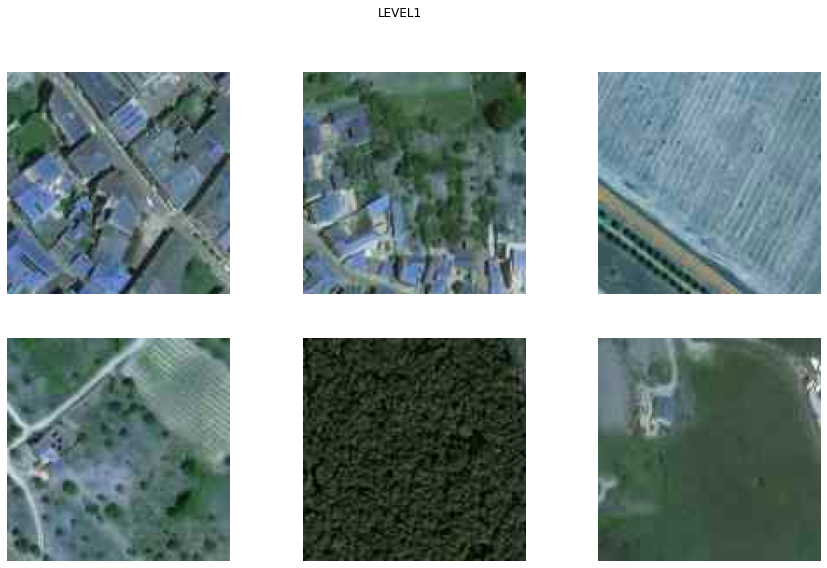

['-8.19514243552109_-8.192901123706804_37.10303984509838_37.104841978914685.jpg', '-8.291518843535393_-8.289277531721106_41.58863076638982_41.590431509266274.jpg', '-8.636680862935453_-8.634439551121169_39.48137517431829_39.4831765759744.jpg', '-8.269105725392532_-8.266864413578245_41.410354420979_41.41215521986161.jpg', '-8.654611357449742_-8.652370045635456_39.229173421445225_39.230974901391626.jpg', '-8.874259915249779_-8.872018603435494_39.162518270697134_39.164319771312044.jpg']


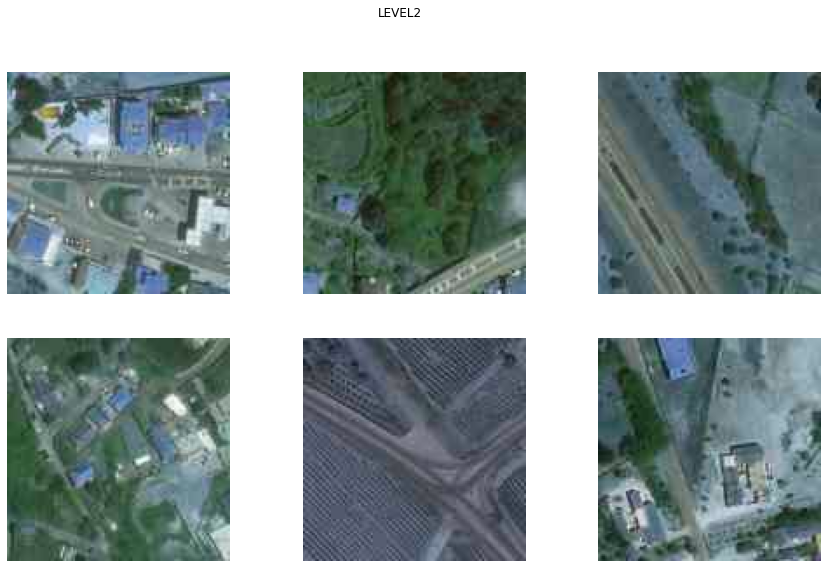

['-9.262006859121275_-9.25976554730699_38.78238916126964_38.78419077956377.jpg', '-7.55636856844955_-7.554127256635263_40.816059930880016_40.81786091613743.jpg', '-7.921702394178183_-7.919461082363899_39.75338048220432_39.7551817992732.jpg', '-8.798055313564053_-8.795814001749767_41.685870071783015_41.687670784093896.jpg', '-7.668434159163855_-7.666192847349569_39.07064099895362_39.07244252804178.jpg', '-8.594095938464019_-8.59185462664973_41.179847496658134_41.18164836789083.jpg']


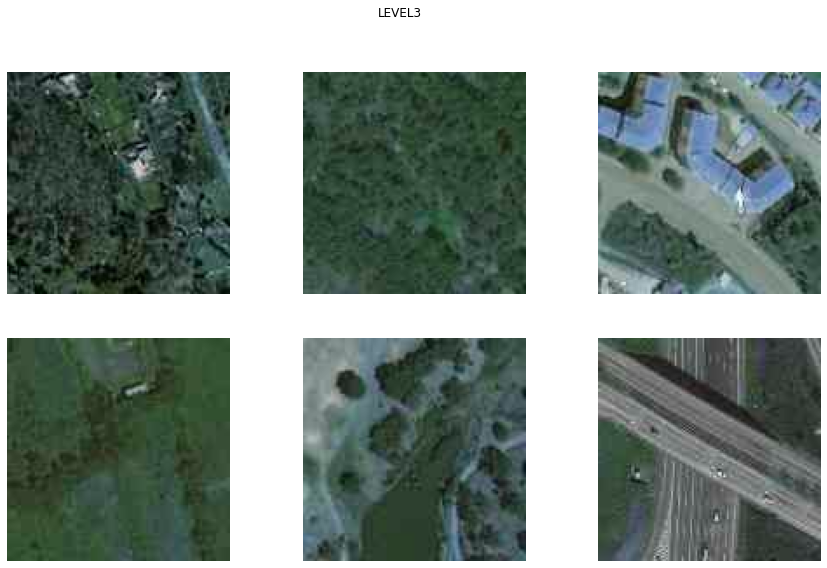

In [17]:
show_sample_images(test,categories)

#### USE GENERATORS TO GET A NUMPY ARRAY TO COMPUTE THE DIFFERNT METRICS USING THE SKLEARN LIBRARY


In [18]:
TEST_SET_COUNT = sum([len(os.listdir(f"{PATH}/{x}")) for x in categories]) 


test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(PATH,
                                            target_size=(image_width, image_height),
                                            batch_size=TEST_SET_COUNT,
                                            class_mode='categorical')

X_test, y_test = test_set.next()

Found 2244 images belonging to 3 classes.


In [32]:
test_set.class_indices

{'LEVEL1': 0, 'LEVEL2': 1, 'LEVEL3': 2}

#### GATHER THE TRAINING HISTORY AND TRAINED MODEL FOR A GIVEN MODEL

In [19]:
def get_past_history(MODEL_HISTORY):
  
  if not os.path.isfile(MODEL_HISTORY):
    return None 
  else:
    history = pd.read_csv(MODEL_HISTORY)
    return history

def get_total_history(past_history,new_history):
  
  history = pd.concat([past_history,new_history], axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)
  return history

def get_past_model(MODEL_FILE):
  
  if not os.path.isfile(MODEL_FILE):
    
    return None 
  else:
    model = load_model(MODEL_FILE)
    return model


#### PLOT THE TRAINING HISTORY

In [20]:
def plot_training_history(history):
  plt.plot(history['categorical_accuracy'])
  plt.plot(history['val_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

#### NECESSARY SKLEARN IMPORTS

In [21]:
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import mean_absolute_error,mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

#### CREATE CONFUSION MATRIX AND COMPUTE METRICS
##### METRICS USED:
*  accuracy
*  mean absolute error
*  mean squared error
*  root mean squared error

In [48]:
def create_confusion_matrix(y_true,y_predict):
  cm =confusion_matrix(y_true, y_predict)  
  print(cm)
  index = ['LEVEL1','LEVEL2','LEVEL3']  
  columns = ['LEVEL1','LEVEL2','LEVEL3']  

  cm_df = pd.DataFrame(cm,columns,index)                      
  plt.figure(figsize=(10,6))  
  sns.heatmap(cm_df, annot=True, fmt='g')

def compute_metrics(model,X_test,y_test):
  
  print(len(y_test))


  y_test = [np.argmax(x) for x in y_test]  

  start = time.time()
  y_predict = np.array([np.argmax(x) for x in model.predict(X_test)])
  end = time.time()

  predict_time = end - start

  print(f"prevision time {predict_time}")
  
  print(f"accuracy {accuracy_score(y_test,y_predict)}")

  print(f"mean absolute error {mean_absolute_error(y_test,y_predict)}")

  mse = mean_squared_error(y_test,y_predict)
  print(f"mean squared error {mse}")

  print(f"root mean squared error {math.sqrt(mse)}")

  create_confusion_matrix(y_test,y_predict)

#### MOBILENET WITHOUT TRANSFER LEARNING AND DATA AUGMENTATION

In [49]:
MODEL = "mobilenet_v2_dataset2.hdf5"
TRAINED_MODEL = f"drive/My Drive/models/{MODEL}"
TRAINING_HISTORY = f"drive/My Drive/history/{MODEL}"
history = get_past_history(TRAINING_HISTORY)
model = get_past_model(TRAINED_MODEL)

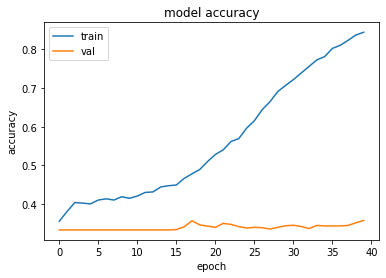

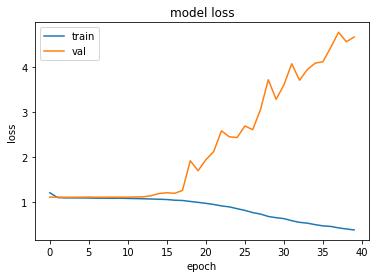

In [50]:
plot_training_history(history)

2244
prevision time 26.243431329727173
accuracy 0.35784313725490197
mean absolute error 0.7562388591800356
mean squared error 0.9844028520499108
root mean squared error 0.9921707776637603
[[137 476 135]
 [107 513 128]
 [121 474 153]]


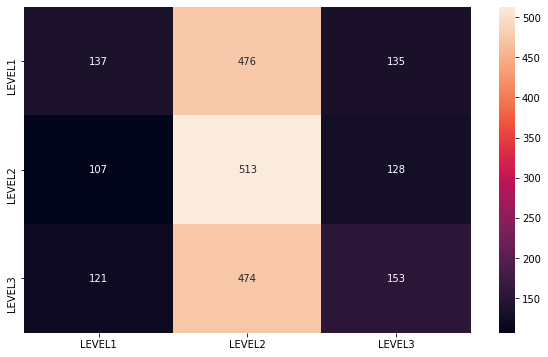

In [51]:
compute_metrics(model,X_test,y_test)

#### INCEPTION V3 WITHOUT TRANSFER LEARNING AND DATA AUGMENTATION

In [52]:
MODEL = "inception_dataset2_2.hdf5"
TRAINED_MODEL = f"drive/My Drive/models/{MODEL}"
TRAINING_HISTORY = f"drive/My Drive/history/{MODEL}"
history = get_past_history(TRAINING_HISTORY)
model = get_past_model(TRAINED_MODEL)

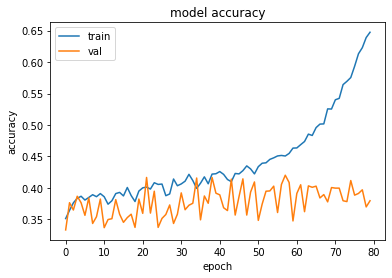

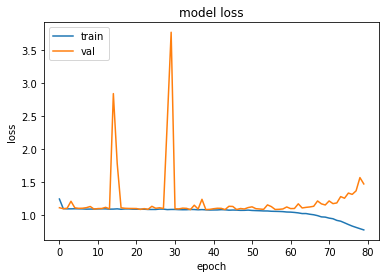

In [53]:
plot_training_history(history)

2244
prevision time 62.78285813331604
accuracy 0.37967914438502676
mean absolute error 0.8373440285204992
mean squared error 1.2713903743315509
root mean squared error 1.1275594770705228
[[270 229 249]
 [208 290 250]
 [238 218 292]]


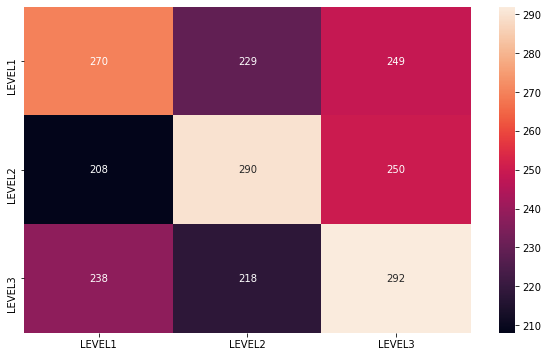

In [54]:
compute_metrics(model,X_test,y_test)

#### RESNET50 WITHOUT TRANSFER LEARNING AND DATA AUGMENTATION

In [61]:
MODEL = "RestNet50.hdf5"
TRAINED_MODEL = f"drive/My Drive/models/{MODEL}"
TRAINING_HISTORY = f"drive/My Drive/history/{MODEL}"
history = get_past_history(TRAINING_HISTORY)
model = get_past_model(TRAINED_MODEL)

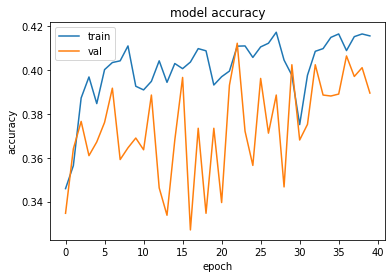

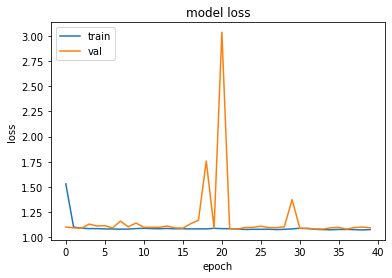

In [62]:
plot_training_history(history)

2244
prevision time 109.34706902503967
accuracy 0.3894830659536542
mean absolute error 0.7736185383244206
mean squared error 1.0998217468805704
root mean squared error 1.0487238658868074
[[225 355 168]
 [169 384 195]
 [198 285 265]]


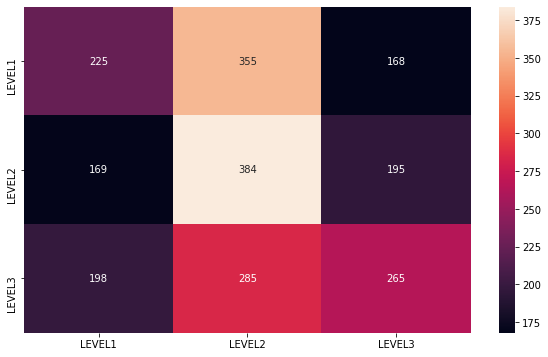

In [63]:
compute_metrics(model,X_test,y_test)

In [55]:
MODEL = "inception_v3_da_tf_dataset2.hdf5"
TRAINED_MODEL = f"drive/My Drive/models/{MODEL}"
TRAINING_HISTORY = f"drive/My Drive/history/{MODEL}"
history = get_past_history(TRAINING_HISTORY)
model = get_past_model(TRAINED_MODEL)

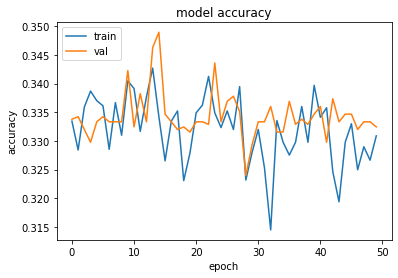

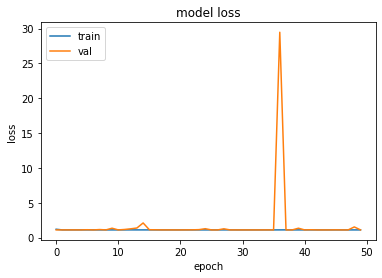

In [56]:
plot_training_history(history)

2244
prevision time 61.64963889122009
accuracy 0.3324420677361854
mean absolute error 1.0017825311942958
mean squared error 1.6702317290552584
root mean squared error 1.2923744538852733
[[746   0   2]
 [748   0   0]
 [748   0   0]]


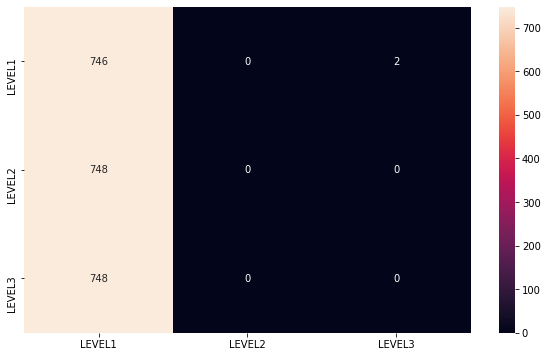

In [57]:
compute_metrics(model,X_test,y_test)

In [58]:
MODEL = "inception_v3_da_dataset2.hdf5"
TRAINED_MODEL = f"drive/My Drive/models/{MODEL}"
TRAINING_HISTORY = f"drive/My Drive/history/{MODEL}"
history = get_past_history(TRAINING_HISTORY)
model = get_past_model(TRAINED_MODEL)

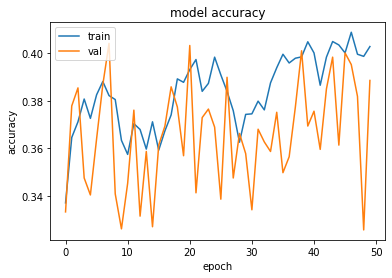

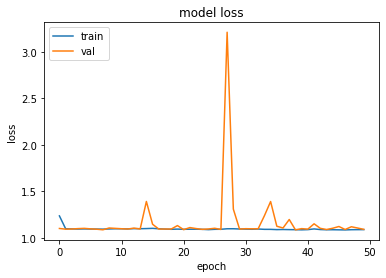

In [59]:
plot_training_history(history)

2244
prevision time 61.19733238220215
accuracy 0.38859180035650626
mean absolute error 0.8101604278074866
mean squared error 1.2076648841354725
root mean squared error 1.09893807111023
[[291 283 174]
 [243 328 177]
 [272 223 253]]


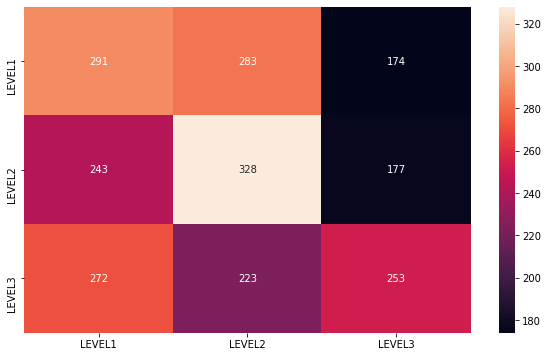

In [60]:
compute_metrics(model,X_test,y_test)